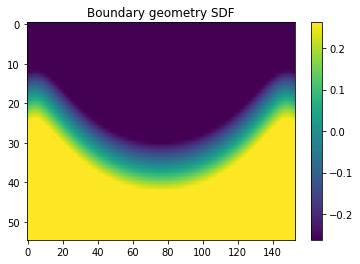

In [1]:
# Load the signed distance function for the boundary geometry

import pickle
import matplotlib.pyplot as plt

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = 'sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the sinusoid 2D sdf
sdf = read_sdf('exact_solution_surface_periodic_0.6', 2)

plt.imshow(sdf.data.T, aspect='auto')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

In [2]:
# Set up the exact solution
import numpy as np

# Use SDF grid
grid = sdf.grid

# Misc parameters
c0 = 1
m = 8
A = 0.25

# Functions required
def x1(x, y, A):
    return x - A*np.sin(x)*np.cosh(y)

def y1(x, y, A):
    return y - A*np.cos(x)*np.sinh(y)

def c(x, y, A, c0):
    term1 = (1-A*np.cos(x)*np.cosh(y))**2
    term2 = (A*np.sin(x)*np.sinh(y))**2
    return c0*(term1 + term2)**-0.5

def alpha(m, c0):
    return c0 + np.sqrt(m**2+(np.pi/2)**2)

def u(t, x, y, c0, m, A):
    x1_vals = x1(x, y, A)
    y1_vals = y1(x, y, A)
    alp = alpha(m, c0)
    return np.cos(m*x1_vals-alp*t)*np.cos(np.pi*y1_vals/2)

xvals = np.linspace(0, 2*np.pi, grid.shape[0]-8)  # Trim off the edges where we will have bcs
yvals = np.linspace(-3*np.pi/4, 0, grid.shape[1])  # -3pi/4

xmsh, ymsh = np.meshgrid(xvals, yvals, indexing='ij')

u0 = u(0, xmsh, ymsh, c0, m, A)

In [3]:
# Need to set up the subdomains
import devito as dv

# Note that we are leaving a 4 point pad on each side to ensure stencils generate correctly
class MainDomain(dv.SubDomain):  # Main section of the grid
    name = 'main'
    def __init__(self):
        super().__init__()            

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', 4, 4), y: ('middle', 0, 2)}
    
class Left(dv.SubDomain):  # Left wraparound region for periodic bcs
    name = 'left'
    def __init__(self):
        super().__init__()

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('left', 4), y: y}
    
class Right(dv.SubDomain):  # Right wraparound region for periodic bcs
    name = 'right'
    def __init__(self):
        super().__init__()

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('right', 4), y: y}

class Base(dv.SubDomain):  # Base with zero flux (centre)
    name = 'base'
    def __init__(self):
        super().__init__()

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', 4, 4), y: ('right', 2)}
    
main_domain = MainDomain()
left = Left()
right = Right()
base = Base()

Operator `Kernel` ran in 0.01 s


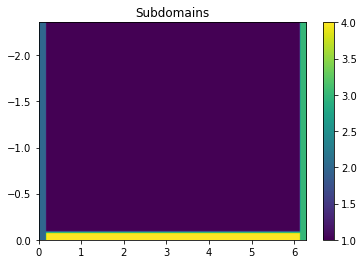

In [4]:
# Dummy equations to check the locations of the subdomains
new_grid = dv.Grid(shape=grid.shape, extent=grid.extent, origin=grid.origin, dimensions=grid.dimensions,
                   subdomains=[main_domain, left, right, base])
f = dv.Function(name='f', grid=grid)
f.data[:] = 0
sub_main = dv.Eq(f, f+1, subdomain=main_domain)
sub_left = dv.Eq(f, f+2, subdomain=left)
sub_right = dv.Eq(f, f+3, subdomain=right)
sub_base = dv.Eq(f, f+4, subdomain=base)

dv.Operator([sub_main, sub_left, sub_right, sub_base])()
plt.imshow(f.data.T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto')
plt.title("Subdomains")
plt.colorbar()
plt.show()

In [5]:
from schism import BoundaryGeometry

# Rebuild the SDF on the new grid so we can use these subdomains

new_sdf = dv.Function(name='sdf', grid=new_grid, space_order=sdf.space_order)
new_sdf.data[:] = sdf.data[:]

bg = BoundaryGeometry(new_sdf)

/home/ed/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ed/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Operator `normals` ran in 0.01 s


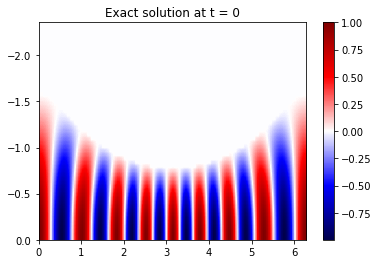

In [6]:
# Plot the solution masked with the interior mask
import sympy as sp

interior_mask = bg.interior_mask[(sp.core.numbers.Zero(), sp.core.numbers.Zero())][4:-4]
# interior_mask = y1(xmsh, ymsh, A) > -1
u0[np.logical_not(interior_mask)] = 0

plt.imshow(u0.T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Exact solution at t = 0")
plt.colorbar()
plt.show()

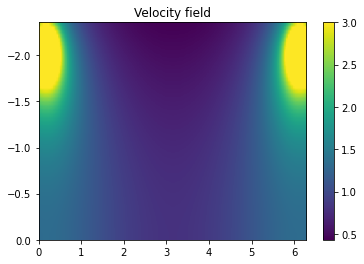

In [7]:
# Set up the velocity field
vel = dv.Function(name='vel', grid=new_grid)
# Cap the velocity at 3, as these points are outside the domain anyway
vel_data = np.minimum(c(xmsh, ymsh, A, c0), 3)
# Add the edges
vel_data_full = np.concatenate((vel_data[:4][::-1], vel_data, vel_data[-4:][::-1]))
vel.data[:] = vel_data_full[:]

plt.imshow(vel.data.T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto')
plt.title("Velocity field")
plt.colorbar()
plt.show()

In [8]:
# Set the timestep at 10% of critical timestep
dt = 0.1*new_grid.spacing[0]/np.amax(vel.data)

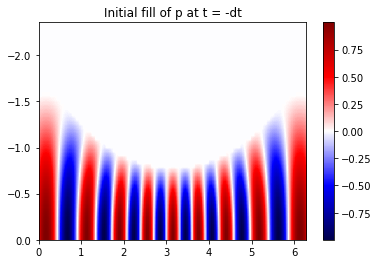

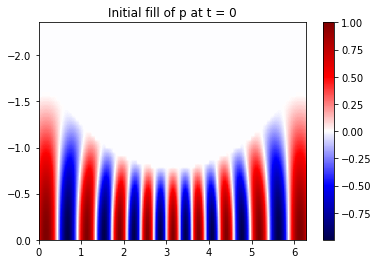

In [9]:
# Set up the TimeFunction
import devito as dv

s_o = 4
p = dv.TimeFunction(name='p', grid=new_grid, space_order=s_o, time_order=2)

un1 = u(-dt, xmsh, ymsh, c0, m, A)
un1[np.logical_not(interior_mask)] = 0

p_data_n1 = np.concatenate((un1[:4][::-1], un1, un1[-4:][::-1]))

p_data_0 = np.concatenate((u0[:4][::-1], u0, u0[-4:][::-1]))

p.data[0] = p_data_n1
p.data[1] = p_data_0

plt.imshow(p.data[0].T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Initial fill of p at t = -dt")
plt.colorbar()
plt.show()

plt.imshow(p.data[1].T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Initial fill of p at t = 0")
plt.colorbar()
plt.show()

In [10]:
# Set up the boundary conditions for the immersed boundary
from schism import BoundaryConditions

bc_list = [dv.Eq(p, 0),  # Zero pressure on free surface
           dv.Eq(p.dx2+p.dy2, 0),  # Zero laplacian
           dv.Eq(p.dx4 + 2*p.dx2dy2 + p.dy4, 0)]  # Zero biharmonic

bcs = BoundaryConditions(bc_list)

In [11]:
# Construct the immersed boundary
from schism import Boundary

boundary = Boundary(bcs, bg)

In [12]:
# Get the modified stencils
derivs = (p.dx2, p.dy2)
subs = boundary.substitutions(derivs)

In [13]:
# Set up the equation for the main body of the domain

# Standard equation with no substitutions
eq_normal = dv.Eq(p.forward, 2*p-p.backward+dt**2*vel**2*(p.dx2+p.dy2), subdomain=main_domain)

eq_main = dv.Eq(p.forward, 2*p-p.backward+dt**2*vel**2*(subs[p.dx2]+subs[p.dy2]), subdomain=main_domain)

In [14]:
# Set up periodic bcs on the left and right edges
# t = p.time_dim
t = new_grid.stepping_dim
# FIXME: Should this be stepping dim instead?
x, y = new_grid.dimensions
left_bcs = [dv.Eq(p[t+1, i, y], p[t+1, new_grid.shape[0]-9+i, y], subdomain=left) for i in range(4)]
right_bcs = [dv.Eq(p[t+1, new_grid.shape[0]-5+i, y], p[t+1, i+4, y], subdomain=right) for i in range(4)]

In [15]:
# Set up the zero flux bc at the base

def zero_flux_base(eq, subdomain):
    """
    Transform an equation such that the stencils are folded back on
    themselves at the edge of the domain.
    """
    lhs, rhs = eq.evaluate.args
    
    yzf = subdomain.dimensions[-1]
    y = yzf.parent
    
    # Functions present in stencil
    funcs = dv.symbolics.retrieve_functions(rhs)
    mapper = {}
    for f in funcs:
        # Get the y index
        yind = f.indices[-1]
        if (yind-y).as_coeff_Mul()[0] > 0:
            pos = abs((f.shape[-1] - 1)*y.spacing - yind)
            mapper.update({f: f.subs({yind: dv.symbolics.INT((f.shape[-1]-1)*y.spacing-pos)})})

    return dv.Eq(lhs, rhs.subs(mapper), subdomain=subdomain)

base_bc = zero_flux_base(eq_normal, base)

In [16]:
# Set up number of timesteps
t_max = 2*np.pi/c0
nsteps = t_max/dt
nsteps

Data(4320.00012567)

In [17]:
op = dv.Operator([eq_main, base_bc] + left_bcs + right_bcs)

In [18]:
# op.apply(dt=dt, t_M=int(nsteps))
op.apply(dt=dt, t_M=20)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.004001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=3e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

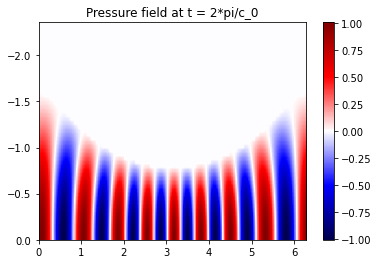

In [19]:
# Remember to trim edges where periodic bcs are applied
# Index in the buffer where the final timestep should be stored:
ind = (1 + int(20)) % 3
plt.imshow(p.data[ind, 4:-4].T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Pressure field at t = 2*pi/c_0")
plt.colorbar()
plt.show()

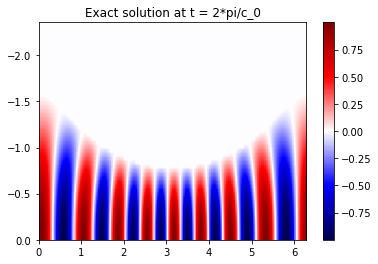

In [20]:
# uend = u(dt*int(nsteps), xmsh, ymsh, c0, m, A)
uend = u(20*dt, xmsh, ymsh, c0, m, A)
uend[np.logical_not(interior_mask)] = 0
plt.imshow(uend.T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Exact solution at t = 2*pi/c_0")
plt.colorbar()
plt.show()

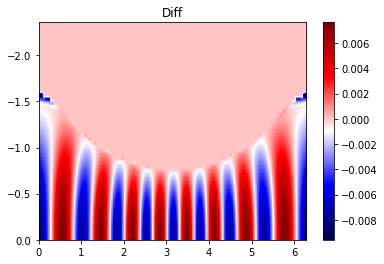

In [21]:
plt.imshow(uend.T-p.data[ind, 4:-4].T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Diff")
plt.colorbar()
plt.show()

0
0.9999902506181121
1.007633


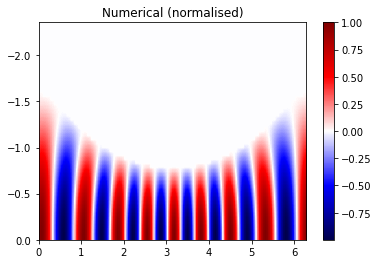

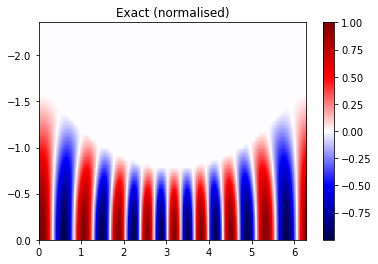

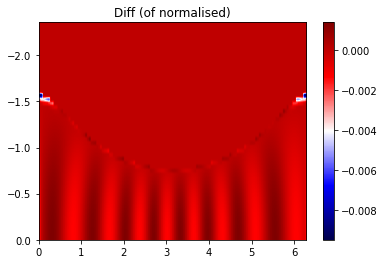

In [22]:
# Plot the difference
print(ind)

print(np.amax(np.abs(uend)))
print(np.amax(np.abs(p.data[ind, 4:-4])))

uend_norm = uend/np.amax(np.abs(uend))
pend_norm = p.data[ind, 4:-4]/np.amax(np.abs(p.data[ind, 4:-4]))

plt.imshow(pend_norm.T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Numerical (normalised)")
plt.colorbar()
plt.show()

plt.imshow(uend_norm.T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Exact (normalised)")
plt.colorbar()
plt.show()


plt.imshow(uend_norm.T-pend_norm.T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Diff (of normalised)")
plt.colorbar()
plt.show()

In [23]:
# Think I need to look into how timefunctions buffer
# And how this interacts with t_M and dt